In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage import measure
from scipy.spatial import ConvexHull
import numpy.fft as fft
import networkx as nx
from skimage import measure
import scipy.stats as stats
import pickle as pkl
import pandas as pd
from mokas_colors import  getPalette
from matplotlib.colors import ListedColormap

import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
from numba import njit
from numba.typed import List

# Utils

In [2]:
def cluster_length(x, y):
    cloud = np.vstack([x-np.mean(x), y-np.mean(y)])
    cov_cloud = np.cov(cloud, rowvar=True, bias=True)
    eigvals, eigvecs = np.linalg.eigh(cov_cloud)
    return np.sqrt(eigvals[1])

In [3]:
def kolton_aggregate(x_data, y_data, n_frames, d_max = 2):
    t_arr = np.array(list(x_data.keys()))
    clustered = {t : False for t in t_arr}
    clusters = []
    for idx, t in enumerate(t_arr):
        if(clustered[t]):
            continue
        clustered[t] = True
        cluster = [t]
        x = x_data[t]
        y = y_data[t]
        for s in t_arr[idx+1:idx+n_frames+1]:
            if(clustered[s]):
                continue
            if((s-t) <= n_frames):
                x_p = x_data[s]
                y_p = y_data[s]
                min_d = np.min(np.abs(x[:,None]-x_p[None,:])+np.abs(y[:,None]-y_p[None,:]))
                if(min_d <= d_max):
                    clustered[s] = True
                    cluster.append(s)
        clusters.append(cluster)
    return clusters

In [4]:
def get_center_manual(z):
    # "-1" profiles
    # sum of columns
    mask1 = (z==-1).sum(axis=0)
    # sum of rows
    mask2 = (z==-1).sum(axis=1)
    # column at which we find the actual interface
    max1 = mask1.max()
    boundary1 = np.argwhere(mask1 == max1).flatten()
    lb1 = np.argmax(np.diff(boundary1))
    # row at which we find the actual interface
    max2 = mask2.max()
    boundary2 = np.argwhere(mask2==max2).flatten()
    lb2 = np.argmax(np.diff(boundary2))
    # actual boundary
    minb_1, maxb_1 = boundary1[lb1],boundary1[lb1+1]
    minb_2, maxb_2 = boundary2[lb2],boundary2[lb2+1]
    # center
    xc = (minb_1+maxb_1)/2
    yc = (minb_2+maxb_2)/2
    # radii
    radius_x = (maxb_1-minb_1)/2
    radius_y = (maxb_2-minb_2)/2
    return xc,yc,radius_x,radius_y

In [5]:
def segment_noevents(data, no_event_val=-1):
    no_event_regions = [ r.astype('int') for r in measure.find_contours(data,no_event_val)]
    no_event_regions_sizes = np.array([r.shape[0] for r in no_event_regions])
    sorted_regions_idx = np.argsort(no_event_regions_sizes)
    inner_region = no_event_regions[sorted_regions_idx[-2]]
    outer_region = no_event_regions[sorted_regions_idx[-1]]
    center = inner_region.mean(axis=0)
    return inner_region,  outer_region, center

In [6]:
def bin_log(data, bins=50, min_exp=None):
    if(type(bins) is int):
        if(min_exp is None):
            binning = np.logspace(np.log10(np.min(data[data>0])),np.log10(np.max(data)), bins)
        else:
            binning = np.logspace(min_exp,np.log10(np.max(data)), bins)
    else:
        binning = bins
    hist, edges = np.histogram(data,bins=binning, density=True)
    mask = hist > 0
    hist = hist[mask]
    #edges = ((edges[0:-1]+edges[1:])*0.5)[mask]
    return hist, edges[0:-1][mask], binning

In [7]:
def arg_groupby(x):
    x_sorted_idx = np.argsort(x)
    x_sorted = x[x_sorted_idx]
    uq_x, uq_i = np.unique(x_sorted, return_index=True)
    return np.split(x_sorted_idx,  uq_i[1:])

In [8]:
frame_to_seconds = {0.13 : 25, 0.14 : 25, 0.15: 25, 0.16 : 25}

In [9]:
for field in [0.13, 0.14, 0.15, 0.16]:
    data = np.loadtxt("data/file_field%1.2f.csv" % field, delimiter=',').astype('int')
    nrows, ncols = data.shape[0], data.shape[1]
    

(0.0, 99.0, 0.0, 99.0)

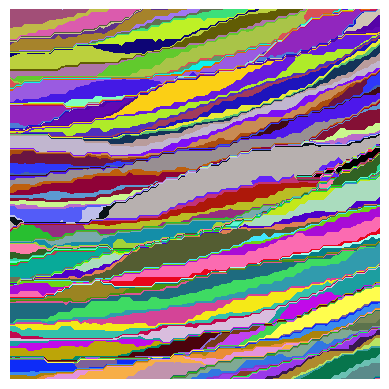

In [10]:
n_pts_plot = data.max()
plot_colors = getPalette(300, 'random', noSwitchColor='black')
lcmap = ListedColormap(plot_colors, )
plt.contourf(data[200:300,600:700], cmap=lcmap, levels=1000)
plt.gca().set_aspect(1)
plt.gca().axis('off')

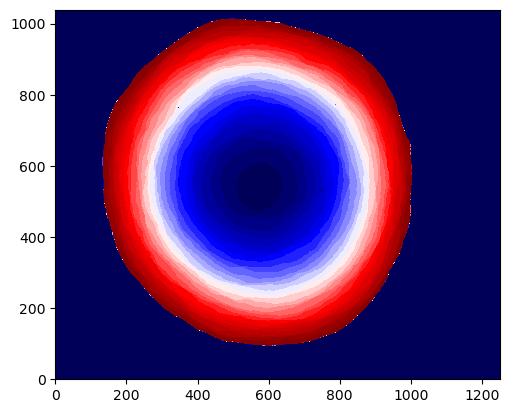

In [11]:
plt.contourf(data, levels=30, cmap='seismic')
plt.gca().set_aspect(1)

# Body

In [10]:
for field in [0.13, 0.14, 0.15, 0.16]:

    data = np.loadtxt("data/file_field%1.2f.csv" % field, delimiter=',').astype('int')
    nrows, ncols = data.shape[0], data.shape[1]
    timesteps, amounts = np.unique(data,return_counts=True)
    timesteps = timesteps[1:]
    amounts = amounts[1:]
    T = timesteps.max() + 1
    topplings = np.zeros(T)
    topplings[timesteps] = amounts
    delta_area = np.cumsum(topplings)

In [10]:
def compute_velocity_waiting_times(r_t):
    dr_t = np.diff(r_t)
    jump_times = np.argwhere(dr_t>0).flatten()
    jumps = dr_t[jump_times]
    waiting_times = np.diff(np.insert(jump_times,0,0))
    velocities = jumps/(waiting_times+1)
    v = np.repeat(velocities,waiting_times )
    return v

(53434, 512)
0.0167167916672426


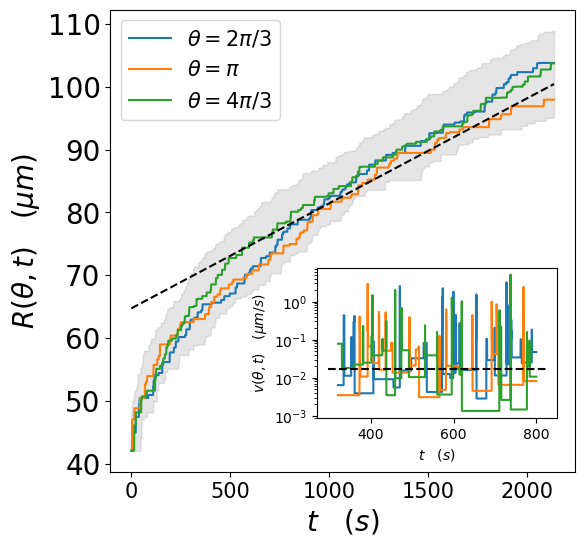

(58650, 512)
0.018414779534232956


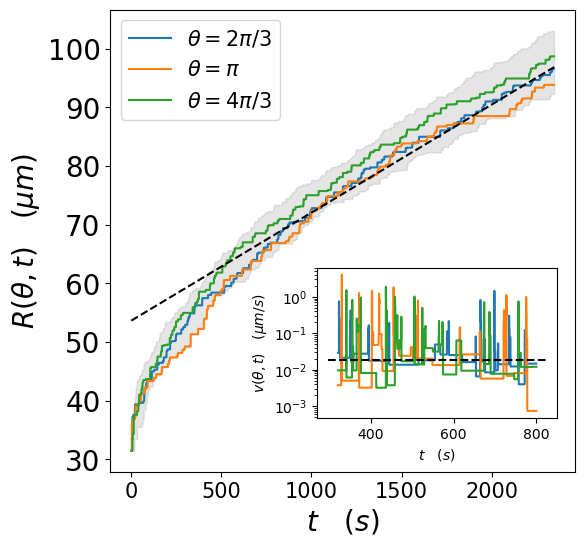

(67880, 512)
0.01853918915278969


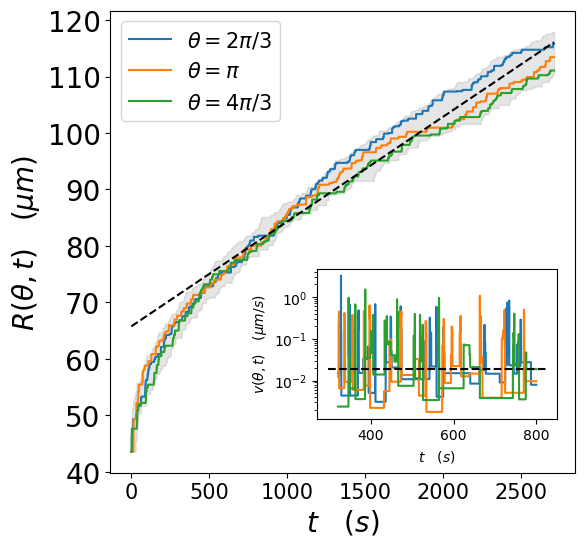

(71674, 512)
0.017903709965405797


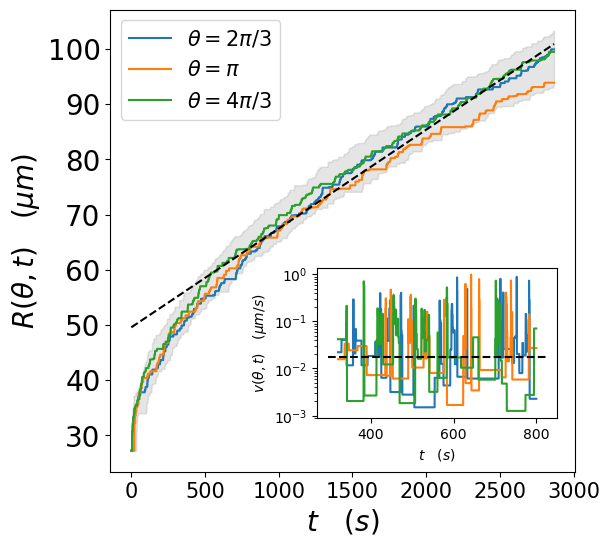

In [11]:
interfaces_dict = {}
r0 = {}
a0 = {}
stat_vels = {}
for field in [0.13, 0.14, 0.15, 0.16]:
    data = np.loadtxt("data/file_field%1.2f.csv" % field, delimiter=',').astype('int')
    nrows, ncols = data.shape[0], data.shape[1]
    x_c_manual, y_c_manual, _, _ = get_center_manual(data)

    # this creates a list of indices per time value
    data_sorted_indices = np.argsort(data.flatten())
    data_sorted = data.flatten()[data_sorted_indices]
    unique_times, uq_i = np.unique(data_sorted, return_index=True)
    grouped_coords = np.split(np.vstack(np.unravel_index(data_sorted_indices, (nrows, ncols))).T,  uq_i[1:], axis=0 )
        
    inner_region, outer_region, center = segment_noevents(data)
    r0[field] = np.sqrt((inner_region[:,0]-center[0])**2+(inner_region[:,1]-center[1])**2).mean()
    #plt.imshow(data)
    blob = np.sqrt((np.arange(0, nrows)[:,None]-center[0])**2 + (np.arange(0, ncols)[None,:]-center[1])**2) <= r0[field]
    blob_where = np.argwhere(blob)
    a0[field] = blob_where.shape[0]
    #plt.scatter(inner_region[:,1], inner_region[:,0], marker='s', s=1)
    #plt.scatter(blob_where[:,1], blob_where[:,0], marker='s', s=1)
    #plt.show()
    grouped_radial = [ np.linalg.norm(gc-center, axis=1)  for gc in grouped_coords ]
    grouped_theta = [ np.arctan2(gc[:,0]-center[0],gc[:,1]-center[1])  for gc in grouped_coords ]
    grouped_total = []
    for c, r, th in zip(grouped_coords, grouped_radial, grouped_theta):
        pack = np.zeros((c.shape[0], 4))
        pack[:, :2] = c
        pack[:, 2]=r
        pack[:, 3] = th
        grouped_total.append(pack) 


    n_theta = 2**9
    dtheta = 2*np.pi/n_theta
    interfaces = [np.zeros(n_theta)]
    thetas = np.linspace(0, 2*np.pi, n_theta)
    time_to_interface_index = {}
    index_to_time = {}
    cnt = 1
    pixel_counter = []
    for t, pack in zip(unique_times, grouped_total):
        if(t>-1):
            time_to_interface_index[t] = cnt
            index_to_time[cnt] = t
            cnt += 1
            theta_i = np.round((pack[:, -1]+np.pi)/dtheta).astype('int') % n_theta
            
            theta_i_groups = arg_groupby(theta_i)
            new_pos = np.copy(interfaces[-1]) #np.zeros(n_theta)
            count = np.zeros(n_theta)
            for angle_indices in theta_i_groups:
                new_pos[theta_i[angle_indices[0]]] = np.mean(pack[angle_indices, -2])
                count [theta_i[angle_indices[0]]] = len(angle_indices)
            pixel_counter.append(count)
                #count[theta_i[angle_indices[0]]] = 
            #np.add.at(delta, theta_i, 1)
            #delta = np.sqrt(delta*2/dtheta)
            interfaces.append(new_pos)
    counter = np.cumsum(np.array(pixel_counter), axis=0)
    radius_counter = np.sqrt(counter/(np.pi*dtheta))
    print(radius_counter.shape)
    interfaces = np.array(interfaces)
    interfaces_dict[field] = (r0[field]+radius_counter,time_to_interface_index,center)
    #interfaces_dict[field] = (radius_counter,time_to_interface_index,center)
    i_start = 20000
    i_end = 50000
    dt_se = (index_to_time[i_end]-index_to_time[i_start]) 
    dr_se = (radius_counter[i_end].mean()-radius_counter[i_start].mean())
    v_stat = dr_se*0.4/(dt_se/frame_to_seconds[field])
    print(v_stat)
    stat_vels[field] = v_stat
    fig, ax  = plt.subplots(figsize=(6,6))
    plt.plot(np.arange(0, radius_counter.shape[0])/frame_to_seconds[field],(r0[field]+radius_counter[:,n_theta//3])*0.4, label="$\\theta=2\pi/3$")
    plt.plot(np.arange(0, radius_counter.shape[0])/frame_to_seconds[field],(r0[field]+radius_counter[:,n_theta//2])*0.4, label="$\\theta=\pi$")
    plt.plot(np.arange(0, radius_counter.shape[0])/frame_to_seconds[field],(r0[field]+radius_counter[:,2*n_theta//3])*0.4, label="$\\theta=4\pi/3$")
    plt.plot(np.arange(0, radius_counter.shape[0])/frame_to_seconds[field],(r0[field]+(radius_counter[i_start,:].mean()+ (np.arange(0, radius_counter.shape[0])-index_to_time[i_start])*dr_se/dt_se ))*0.4, ls='dashed', color='black')
    plt.fill_between(np.arange(0, radius_counter.shape[0])/frame_to_seconds[field], (r0[field]+np.min(radius_counter, axis=1))*0.4,  (r0[field]+np.max(radius_counter, axis=1))*0.4, color='grey', alpha=0.2)
    plt.xlabel("$t \quad (s)$", fontsize=20)
    plt.ylabel("$R(\\theta,t) \quad (\mu m)$", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=20)

    plt.legend(fontsize=15,)
    cax = fig.add_axes([0.47, 0.2,0.4, 0.25])
    v_1 = compute_velocity_waiting_times(radius_counter[:, n_theta//3])
    v_2 = compute_velocity_waiting_times(radius_counter[:, n_theta//2])
    v_3 = compute_velocity_waiting_times(radius_counter[:, 2*n_theta//3])
    cax.plot(np.arange(0, len(v_1))[8000:20000]/frame_to_seconds[field], v_1[8000:20000]*0.4*frame_to_seconds[field],label="$\\theta=2\pi/3$")
    cax.plot(np.arange(0, len(v_2))[8000:20000]/frame_to_seconds[field], v_2[8000:20000]*0.4*frame_to_seconds[field],label="$\\theta=\pi$")
    cax.plot(np.arange(0, len(v_3))[8000:20000]/frame_to_seconds[field], v_3[8000:20000]*0.4*frame_to_seconds[field],label="$\\theta=4\pi/3$")
    cax.hlines(v_stat, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], ls='dashed', color='black')
    cax.set_yscale('log')
    cax.set_xlabel("$t \quad (s)$")
    cax.set_ylabel("$v(\\theta,t) \quad (\mu m/s)$")
    plt.show()
    #plt.plot(np.arange(0, interfaces.shape[0]),interfaces[:, n_theta//2])
    #plt.plot(np.arange(0, interfaces.shape[0]), interfaces[:, n_theta//4])
    #plt.plot(np.arange(0, interfaces.shape[0]), interfaces[:, n_theta//8])
    ##print(np.diff(interfaces[10000:, n_theta//2]).mean())
    
    #plt.show()

# Network

In [ ]:
xs = [gc[:, 0] for gc in grouped_total  ][1:]
ys = [gc[:, 1] for gc in grouped_total  ][1:]
ts = unique_times[1:]

In [ ]:
def build_network(xs,ys,times,time_cut,tol=2):
    network = {}
    for idx, (t,x,y) in enumerate(zip(times,xs,ys)):
        network[t] = []
        for (s,u,v) in zip(times[idx+1:],xs[idx+1:],ys[idx+1:]):
            if((s-t)>time_cut):
                break
            if(np.min(np.abs(x.reshape(-1,1)-u.reshape(1,-1))+np.abs(y.reshape(-1,1)-v.reshape(1,-1))) <=tol):
                network[t].append(s)
    return network

In [ ]:
net = build_network(xs, ys, ts, 5, 2)

In [ ]:
g = nx.Graph()
g.add_nodes_from(net.keys())
for k, v in net.items():
    g.add_edges_from(([(k, t) for t in v]))
sub_graphs = nx.connected_components(g)
clusters = [ np.sort(np.array(list(sg))) for sg in sub_graphs]

In [ ]:
avalanches = []
for cluster in clusters:
    avalanche = 0
    for time in cluster:
        if(time in time_to_interface_index.keys()):
            idx = time_to_interface_index[time]
            if(idx>0):
                avalanche += np.sum(interfaces[idx, :]-interfaces[idx-1, :])
    avalanches.append(avalanche)

In [ ]:
hist,edges = np.histogram(avalanches, bins=np.logspace(-4,4.5), density=True)
plt.scatter(edges[:-1], hist)
plt.plot(edges[:-1], 1/edges[:-1]**1.5)
plt.xscale('log')
plt.yscale('log')

# Clustering

In [ ]:
field = 0.15
data = np.loadtxt("data/file_field%1.2f.csv" % field, delimiter=',').astype('int')
nrows, ncols = data.shape[0], data.shape[1]
load = False
if(load):
    with open('clusters_data/file_field%1.2f.pkl' % field, 'rb') as f:
        x_dict, y_dict, t_dict = pkl.load(f)
else:
    t0=0
    max_t = data.max()
    x_dict = {}
    y_dict = {}
    t_dict = {}

    for t in range(0,max_t+1):
        if(t % 2000 == 0):
            print("Status: %2.1f%%" % (100*(t-t0)/(max_t+1-t0)))
        positions = np.argwhere(data==t)
        if(len(positions)>0):
            x_dict[t] = positions[:,0]
            y_dict[t] = positions[:,1]
            t_dict[t] = t
    with open('clusters_data/file_field%1.2f.pkl' % field, 'wb') as f:
        pkl.dump([x_dict, y_dict, t_dict], f)
xs = [x_dict[t] for t in t_dict]
ys = [y_dict[t] for t in t_dict]
ts = list(t_dict.keys())

In [ ]:
def build_network(xs,ys,times,time_cut,tol=2):
    network = {}
    for idx, (t,x,y) in enumerate(zip(times,xs,ys)):
        network[t] = []
        for (s,u,v) in zip(times[idx+1:],xs[idx+1:],ys[idx+1:]):
            if((s-t)>time_cut):
                break
            if(np.min(np.abs(x.reshape(-1,1)-u.reshape(1,-1))+np.abs(y.reshape(-1,1)-v.reshape(1,-1))) <=tol):
                network[t].append(s)
    return network

In [24]:
time_cuts = [6,8,10,12,14,16,18,20]
tols = [2, 3, 4]

In [21]:
net_coll = []
for tcut in time_cuts:
    print('t_cut', tcut)
    nets = []
    for tol in tols:
        print('tol', tol)
        net = build_network(xs,ys,ts,tcut,tol)
        nets.append(net)
    net_coll.append(nets)
with open('clusters_data/file_cluster%1.2f.pkl' % field, 'wb') as f:
    pkl.dump([time_cuts, tols, net_coll], f)

# Basic Frame Corr

331

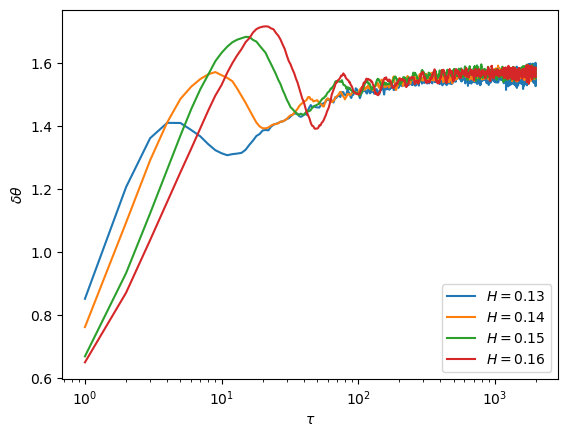

In [86]:
for m_field in [0.13,0.14, 0.15, 0.16]:
    with open('clusters_data/file_field%1.2f.pkl' % m_field, 'rb') as f:
        x_dict, y_dict, t_dict = pkl.load(f)
    data = np.loadtxt("data/file_field%1.2f.csv" % m_field, delimiter=',').astype('int')
    inner_region, outer_region, center = segment_noevents(data)
    x_avg = []
    y_avg = [] 
    times = []
    for t in x_dict.keys():
        x_avg.append(x_dict[t].mean())
        y_avg.append(y_dict[t].mean())
        times.append(t)
    x_avg = np.array(x_avg)
    y_avg = np.array(y_avg)
    times = np.array(times)
    thetas = np.pi+np.arctan2(x_avg-center[0], y_avg-center[1])
    time_corr = []
    for step in range(1,2000):
        t0 = times[:-step]
        dt = times[step:] - t0
        dth = np.abs(thetas[step:] - thetas[:-step])
        dth = np.minimum(2*np.pi-dth, dth)
        mask = (dt == step)
        time_corr.append((step, dth[mask].mean()))
    time_corr = np.array(time_corr)
    plt.plot(time_corr[:,0], time_corr[:,1], label='$H=%1.2f$' % m_field)
plt.xlabel("$\\tau$")
plt.ylabel("$\delta \\theta$")
plt.legend()
plt.xscale('log')
plt.show()

# Exec

In [12]:
res_dict = {}
for m_field in [0.13,0.14, 0.15, 0.16]:
    img_data = np.loadtxt("data/file_field%1.2f.csv" % m_field, delimiter=',').astype('int')
    nrows, ncols = img_data.shape[0], img_data.shape[1]
    x_c_manual, y_c_manual, _, _ = get_center_manual(img_data)
    print(m_field)
    with open('clusters_data/file_cluster%1.2f.pkl' % m_field, 'rb') as f:
        time_cuts, tols, net_coll = pkl.load(f)
    with open('clusters_data/file_field%1.2f.pkl' % m_field, 'rb') as f:
        x_dict, y_dict, t_dict = pkl.load(f)
    xs = [x_dict[t] for t in t_dict]
    ys = [y_dict[t] for t in t_dict]
    ts = list(t_dict.keys())
    cl_coll = []
    for tcut, nets in zip(time_cuts, net_coll):
        clusters = []
        for tol, net in zip(tols, nets):
            g = nx.Graph()
            g.add_nodes_from(net.keys())
            for k, v in net.items():
                 g.add_edges_from(([(k, t) for t in v]))
            sub_graphs = nx.connected_components(g)
            clusters.append([ np.sort(np.array(list(sg))) for sg in sub_graphs])
        cl_coll.append(clusters)
    for tc_idx in range(len(time_cuts)):
        for tol_idx in range(len(tols)):
            print(time_cuts[tc_idx], tols[tol_idx])
            c_image = np.zeros_like(img_data)
            #fig, ax = plt.subplots(ncols=3, figsize=(24,8))
            clc = cl_coll[tc_idx][tol_idx]
            pixel_counts = []
            l_min = []
            l_plus = []
            cluster_times = {}

            epicenters = []

            for cluster_cnt, c in enumerate(clc):
                epicenters.append((c[0], x_dict[c[0]].mean(), y_dict[c[0]].mean()))
                cluster_times[cluster_cnt] = []
                x_cl = []
                y_cl = []
                size = 0
                for t_idx in c:
                    size += len(x_dict[t_idx])
                    x_cl.append(x_dict[t_idx])
                    y_cl.append(y_dict[t_idx])
                    c_image[x_cl[-1], y_cl[-1]] = cluster_cnt
                    cluster_times[cluster_cnt].append(t_idx)
                pixel_counts.append(size)
                x_cl = np.concatenate(x_cl)
                y_cl = np.concatenate(y_cl)
                # the cluster is made of at least one pixel
                if(len(x_cl)>1):
                    cloud = np.vstack([x_cl-np.mean(x_cl), y_cl-np.mean(y_cl)])
                    cov_cloud = np.cov(cloud)
                    eigvals, eigvecs = np.linalg.eigh(cov_cloud)
                    l_plus.append(eigvals[1])
                    l_min.append(eigvals[0])
                else:
                    single_pixel_angle = np.arctan2((x_cl[0]-x_c_manual), (y_cl[0]-y_c_manual))
                    major_semiaxis=(1+(np.sqrt(2)-1)*np.abs(np.sin(single_pixel_angle)))/2
                    l_plus.append(0)
                    l_min.append(0)
            epicenters = np.array(epicenters)
            pixel_counts = np.array(pixel_counts)
            l_min = np.array(l_min)
            l_plus = np.array(l_plus)
            res_dict[(m_field, time_cuts[tc_idx], tols[tol_idx])] = (pixel_counts, l_plus, l_min, c_image, cluster_times, epicenters)

0.13
8 2
8 3
8 4
10 2
10 3
10 4
12 2
12 3
12 4
14 2
14 3
14 4
16 2
16 3
16 4
18 2
18 3
18 4
20 2
20 3
20 4
0.14
8 2
8 3
8 4
10 2
10 3
10 4
12 2
12 3
12 4
14 2
14 3
14 4
16 2
16 3
16 4
18 2
18 3
18 4
20 2
20 3
20 4
0.15
8 2
8 3
8 4
10 2
10 3
10 4
12 2
12 3
12 4
14 2
14 3
14 4
16 2
16 3
16 4
18 2
18 3
18 4
20 2
20 3
20 4
0.16
8 2
8 3
8 4
10 2
10 3
10 4
12 2
12 3
12 4
14 2
14 3
14 4
16 2
16 3
16 4
18 2
18 3
18 4
20 2
20 3
20 4


### $ P(S) $ with various $\Delta t$

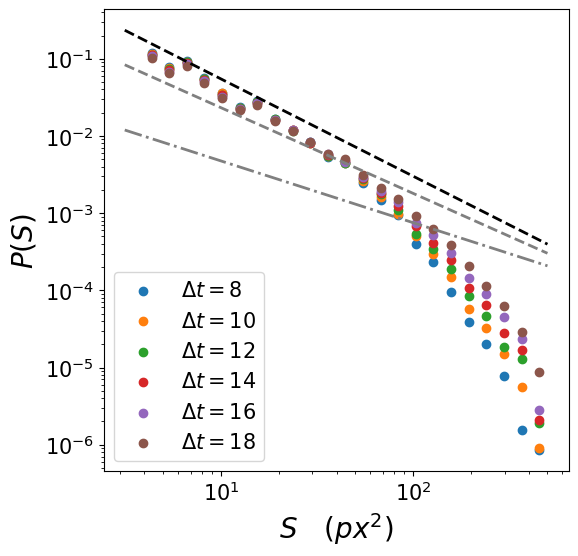

In [14]:
field_to_plot = 0.14
tol_to_plot = 3
fig, ax = plt.subplots(figsize=(6,6))

for tc in range(8,20,2):
    v = res_dict[(field_to_plot, tc,tol_to_plot)]
    hist, edges = np.histogram(v[0], bins=np.logspace(0.5, 2.7, 25), density=True)
    plt.scatter((edges[:-1]+edges[1:])/2, hist, label='$\Delta t=%i$' %tc)
plt.plot(edges,edges**(-1.26), ls='dashed', c='black', lw=2)
plt.plot(edges,0.3*edges**(-1.11), ls='dashed', c='grey', lw=2)
plt.plot(edges,0.03*edges**(-4/5), ls='-.', c='grey', lw=2)
plt.legend(fontsize=15, loc='lower left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$S \quad (px^2)$", fontsize=20)
plt.ylabel("$P(S)$", fontsize=20)
#ax_top = ax.secondary_xaxis('top')
#top_ticks = 0.4*0.4*np.array(ax.get_xticks())
#ax_top.set_xticks(ax.get_xticks(),[ '$%1.1f \\times 10^{%i}$' % (tp/10**int(np.log10(tp)), int(np.log10(tp))) for tp in top_ticks], fontsize=15)
#ax_top.set_xlabel("$S \quad (\mu m^2)$", fontsize=15)
plt.show()
    

### Observables and plots

In [13]:
chosen_timecut = 16
chosen_tol = 3
chosen_res = {}
for k, v in res_dict.items():
    if(k[2]==chosen_tol and k[1] == chosen_timecut):
        maj_ax = np.sqrt(v[1])
        min_ax = np.sqrt(np.abs(v[2]))
        area_ellipse = maj_ax*min_ax
        avalanche_sizes = v[0]
        mask = (maj_ax >0)*(min_ax > 0)
        eigs_scaling = stats.linregress(area_ellipse[mask], avalanche_sizes[mask])
        axis_to_pixel = np.sqrt(eigs_scaling[0]/np.pi)
        ell=maj_ax[mask]*axis_to_pixel
        avs = avalanche_sizes[mask]
        chosen_res[k] = (avs, ell, maj_ax, min_ax, avalanche_sizes, v[-1])

In [42]:
#for cnt, m_field in enumerate([0.13,0.14, 0.15, 0.16]):
#    raw_data = np.loadtxt("data/file_field%1.2f.csv" % m_field, delimiter=',').astype('int')
#    img_data = res_dict[(m_field, chosen_timecut, chosen_tol)][3]
#    n_pts_plot = img_data.max()
#    plot_colors = getPalette(n_pts_plot, 'random', noSwitchColor='black')
#    lcmap = ListedColormap(plot_colors, )
#    fig, ax = plt.subplots()
#    #ax.contourf(raw_data[200:300,600:700], cmap=lcmap, levels=1000)
#    ax.imshow(raw_data, cmap=lcmap)
#    ax.set_aspect(1)
#    plt.ylim(500,600)
#    plt.xlim(400,500)
#    ax.axis('off')
#    plt.show()
    #idx_min = 0
    #idx_max = img_data.max()
    #print(idx_max, raw_data.max())
    #n_pts_plot = idx_max - idx_min - 1
    #plot_colors = getPalette(n_pts_plot, 'random', noSwitchColor='black')
    #lcmap = ListedColormap(plot_colors, n_pts_plot)
    #inner_region, outer_region, center = segment_noevents(img_data,0)
    ##nrows, ncols = img_data.shape[0], img_data.shape[1]
    #
    #plt.imshow(img_data, cmap=lcmap)
    #plt.xlim(center[1]-150, center[1]+150)
    #plt.ylim(center[0]-150, center[0]+150)
    #plt.xticks(ticks=np.arange(center[1]-150,center[1]+200, 50 ), labels=np.floor(np.arange(-150,200, 50 )*0.4), fontsize=12)
    #plt.yticks(ticks=np.arange(center[0]-150,center[0]+200, 50 ), labels=np.floor(np.arange(-150,200, 50 )*0.4), fontsize=12)
    #plt.xlabel("$x-x_c \quad (\mu m)$", fontsize=15)
    #plt.ylabel("$y-y_c \quad (\mu m)$", fontsize=15)
    #plt.savefig('cluster_events_%i.png' % cnt, dpi=600)
    #plt.show()

In [17]:
for k, v in res_dict.items():
    if(k[2]==chosen_tol and k[1] == chosen_timecut):
        print(k[0])
        data = np.loadtxt("data/file_field%1.2f.csv" % k[0], delimiter=',').astype('int')
        nrows, ncols = data.shape[0], data.shape[1]
        with open('clusters_data/file_field%1.2f.pkl' % k[0], 'rb') as f:
            x_dict, y_dict, t_dict = pkl.load(f)
        x_c_manual, y_c_manual, _, _ = get_center_manual(data)

        xs = [x_dict[t] for t in t_dict]
        ys = [y_dict[t] for t in t_dict]
        ts = list(t_dict.keys())






        intf,t_to_idx,center  = interfaces_dict[k[0]]
        thetas = np.linspace(-np.pi, np.pi, intf.shape[1])
        index_to_plot = np.argwhere(np.array(ts) ==  np.min(list(v[-1].values())[np.argmax([len(_) for _ in v[-1].values()])])).flatten()[0]
        index_to_stop = index_to_plot + 200
        index_to_plot += 50
        time_to_plot = ts[index_to_plot]
        time_to_stop = ts[index_to_stop]

        #plt.imshow(data, cmap='Greys')
        #plt.scatter(center[1]+intf[index_to_plot]*np.cos(thetas),center[0] + intf[index_to_plot]*np.sin(thetas), s=0.5, c='black')
        #plt.scatter(center[1]+intf[index_to_stop]*np.cos(thetas),center[0] + intf[index_to_stop]*np.sin(thetas), s=1, c='black')
        unique_cluster_codes = set()
        for c_key, c_times in v[-1].items():
            unique_cluster_codes.add(c_key)
            if(time_to_plot in c_times):
                time_to_plot = min(time_to_plot, np.min(c_times))
            if(time_to_stop in c_times):
                time_to_stop = max(time_to_stop, np.max(c_times))
        unique_cluster_codes = np.sort(np.array(list(unique_cluster_codes)))
        print(time_to_plot, time_to_stop)
            #if(time_to_plot in c_times):
            #    c_start = c_key
            #if(time_stop in c_times):
            #    c_end = c_key
        #print(c_end-c_start)
        #my_colormaps = ['Reds','Blues','Oranges','Greens']
        #unique_indices = set()
        #for c_key in range(c_start, c_end):
        #    ck_t = v[-1][c_key]
        #    print(np.max(ck_t))
        #    #cluster_pos = []
        #    my_cmap = matplotlib.cm.get_cmap(my_colormaps[c_key % 4])
        #    for counter,t_idx in enumerate(ck_t):
        #        idx_t = np.argwhere(ts == t_idx).flatten()[0]
        #        unique_indices.add(idx_t)
        ##diff_spots = np.argwhere(intf[idx_t]-intf[idx_t-1] != 0).flatten()
        #unique_indices = np.sort(list(unique_indices))

        #for idx_t in unique_indices:
            #intf_smooth = np.convolve(intf[idx_t], np.ones(5)/5)
        blue_clusters = []
        red_clusters = []
        blue_pts = []
        red_pts = []
        theta_cut = 2.4
        first_idx_to_plot = -1
        for tp in range(time_to_plot, time_to_stop+1):
            if(tp in t_to_idx):
                idx_t = t_to_idx[tp]
                du = np.convolve(intf[idx_t]-intf[idx_t-1], np.ones(5)/5)[2:-2]
                displ_idx = np.argwhere(du>0).flatten()
                if(len(displ_idx) == 0):
                    continue
                if(first_idx_to_plot==-1):
                    first_idx_to_plot = idx_t
                pis = np.convolve(intf[idx_t-1], np.ones(5)/5)[2:-2]
                cis = np.convolve(intf[idx_t], np.ones(5)/5)[2:-2]
                if(thetas[displ_idx][0] < 2.4):
                    blue_clusters.append(idx_t)
                    blue_pts.append((idx_t,thetas[displ_idx], pis[displ_idx],cis[displ_idx]))
                else:
                    red_clusters.append(idx_t)
                    red_pts.append((idx_t,thetas[displ_idx], pis[displ_idx],cis[displ_idx]))
                #plt.plot(thetas ,  np.convolve(intf[idx_t], np.ones(5)/5)[2:-2], lw=0.5, c='black')
                #plt.fill_between(thetas[displ_idx], intf[idx_t-1, displ_idx],intf[idx_t, displ_idx])
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(thetas, 0.4*np.convolve(intf[first_idx_to_plot,:], np.ones(5)/5)[2:-2], lw=1, color='black')
        blue_cm = matplotlib.cm.get_cmap('Blues')
        red_cm = matplotlib.cm.get_cmap('Reds')
        for cnt, (bc, bp) in enumerate(zip(blue_clusters, blue_pts)):
            plt.fill_between(bp[1], 0.4*bp[2], 0.4*bp[3], color=blue_cm(cnt/len(blue_pts)))
            plt.plot(bp[1], 0.4*bp[3], color='black', lw=1)
        for cnt, (bc, bp) in enumerate(zip(red_clusters, red_pts)):
            plt.fill_between(bp[1], 0.4*bp[2], 0.4*bp[3], color=red_cm(cnt/len(red_pts)))
            plt.plot(bp[1],0.4*bp[3], color='black', lw=1)
        plt.xlim(1.7,np.pi*0.99)
        #plt.ylim(0.4*175,0.4*195)
        plt.ylim(56,60)
        
                #pos_t = np.argwhere(data == t_idx)
                #cluster_pos.append(pos_t)
                #plt.scatter(pos_t[:,1], pos_t[:,0], marker='s', s=5, color=my_cmap(counter/len(ck_t)))
            #cluster_pos = np.concatenate(cluster_pos, axis=0)

            #try:
            #    hull  = ConvexHull(cluster_pos)
            #    vertices = cluster_pos[hull.vertices,:]
            #    vertices = np.vstack((vertices, vertices[0,:]))
            #    plt.plot(vertices[:,1], vertices[:,0],  lw=0.5, color='black')
            #except:
            #    continue
               
        #plt.gca().invert_yaxis()
        
        #for tp in range(time_to_plot, time_to_plot+200):
        #    if(tp in x_dict):
        #        plt.scatter(y_dict[tp],x_dict[tp], marker='s', s=1)
        #plt.xlim(center[1]-200, center[1]+200)
        #plt.ylim(center[0]-200, center[0]+200)
        #plt.xlim(400,550)
        #plt.ylim(350, 450)
        #plt.ylim(400,550)
        plt.xlabel('$\\theta \quad (\\rm{rad})$', fontsize=20)
        plt.ylabel('$R(\\theta, t) \quad (\mu m)$', fontsize=20)
        plt.text(2, 57.5,s="$t_{\\rm init}=%i$ s" % (time_to_plot/frame_to_seconds[k[0]]), fontsize=20)
        plt.text(2.45, 59,s="$t_{\\rm final}=%i$ s" % (time_to_stop/frame_to_seconds[k[0]]), fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks( fontsize=20)
        cax = fig.add_axes([0.1, 0.15, 0.25, 0.25])
        pic_x = 0.4*np.convolve(intf[first_idx_to_plot,:], np.ones(5)/5)[2:-2]*np.cos(thetas)
        pic_y = 0.4*np.convolve(intf[first_idx_to_plot,:], np.ones(5)/5)[2:-2]*np.sin(thetas)
        cax.plot(pic_x[2:-2], pic_y[2:-2], color='black')
        pic_x = 0.4*np.convolve(intf[time_to_stop,:], np.ones(5)/5)[2:-2]*np.cos(thetas)
        pic_y = 0.4*np.convolve(intf[time_to_stop,:], np.ones(5)/5)[2:-2]*np.sin(thetas)
        cax.plot(pic_x[2:-2], pic_y[2:-2], color='black')
        cax.set_xticks([])
        cax.set_yticks([])
        cax.set_aspect('equal')
        cax.axis('off')
        plt.show()
        #rs_mean = {t:np.sqrt((x-x_c_manual)**2+(y-y_c_manual)**2).mean() for t,x, y in zip(ts,xs, ys)}
        
        #plt.plot(rs_mean.keys(), np.maximum.accumulate(list(rs_mean.values())))
    

0.13


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
@njit
def epi_dist_radial(times, radii, angles):
    time_diffs = List()
    #rad_dist = List()
    ang_dist = List()
    for i, (t_i, r_i, th_i) in enumerate(zip(times, radii, angles)):
        for t_j, r_j, th_j in zip(times, radii, angles):
            dt_ji = t_j - t_i
            if(dt_ji>0):
                time_diffs.append(dt_ji)
                dth_ji = np.abs(th_j - th_i)
                dth_ji = min(dth_ji, 2*np.pi-dth_ji)
                #rad_dist.append(np.abs(r_j-r_i))
                ang_dist.append(dth_ji)
    return time_diffs, ang_dist

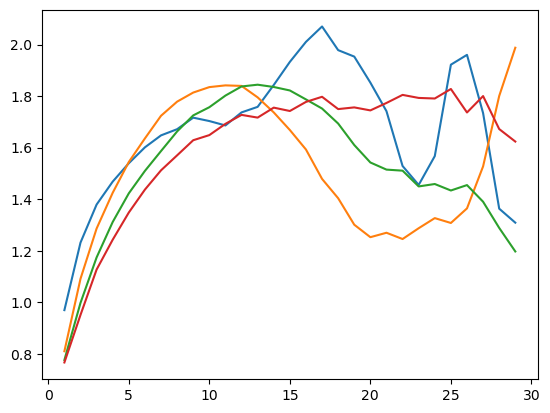

In [81]:
basename = "data/file_field"
for field in [0.13, 0.14, 0.15, 0.16]:
    filename = basename + "%1.2f_events.pkl" % field
    with open(filename, 'rb') as file:
        xs, ys = pkl.load(file)
    kolton_clusters = kolton_aggregate(xs, ys, 3)

    kolton_sizes = []
    kolton_lengths = []
    kolton_epicenters = []
    for clus in kolton_clusters:
        kolton_epicenters.append((clus[0], xs[clus[0]].mean(), ys[clus[0]].mean()))
        kolton_sizes.append(np.sum([len(xs[c]) for c in clus]))
        kolton_lengths.append( cluster_length(np.concatenate([ xs[c]  for c in clus]), np.concatenate([ ys[c]  for c in clus])))
    kolton_sizes = np.array(kolton_sizes)
    kolton_lengths = np.array(kolton_lengths)
    kolton_epicenters = np.array(kolton_epicenters)

    

    sizes = chosen_res[(field, chosen_timecut, chosen_tol)][0]
    lengths = chosen_res[(field, chosen_timecut, chosen_tol)][1]
    epicenters = chosen_res[(field, chosen_timecut, chosen_tol)][-1]
    times = epicenters[:,0]
    data = np.loadtxt("data/file_field%1.2f.csv" % field, delimiter=',').astype('int')
    inner_region, outer_region, center = segment_noevents(data)
    epicenters_th =  np.pi+np.arctan2(epicenters[:, 1] - center[0], epicenters[:, 2] - center[1])
    kolton_epicenters_th =  np.pi+np.arctan2(kolton_epicenters[:, 1] - center[0], kolton_epicenters[:, 2] - center[1])
    epicenters_r =  np.sqrt((epicenters[:, 1] - center[0]  )**2 + (epicenters[:,2] - center[1]  )**2)
    kolton_epicenters_r =  np.sqrt((kolton_epicenters[:, 1] - center[0]  )**2 + (kolton_epicenters[:,2] - center[1]  )**2)
    
    
    epi_dt, epi_dth = epi_dist_radial(epicenters[:,0], epicenters_r,epicenters_th % 2*np.pi)
    epi_df = pd.DataFrame() 
    epi_df['dt'] = epi_dt
    #epi_df['dr'] = epi_dr
    epi_df['dth'] = epi_dth

    kolton_epi_dt, kolton_epi_dth = epi_dist_radial(kolton_epicenters[:,0], kolton_epicenters_r,kolton_epicenters_th % 2*np.pi)
    kolton_epi_df = pd.DataFrame() 
    kolton_epi_df['dt'] = kolton_epi_dt
    #kolton_epi_df['dr'] = kolton_epi_dr
    kolton_epi_df['dth'] = kolton_epi_dth
    #epi_dr = np.abs(epicenters_r[:, None] - epicenters_r[None, :])
    #epi_dth = np.abs((epicenters_th % 2*np.pi)[:,None] - (epicenters_th % 2*np.pi)[None,:])
    #epi_dth = np.minimum(epi_dth, 2*np.pi-epi_dth)
    #epi_dt = epicenters[:,0][:,None]-epicenters[:,0][None,:]
    #epi_df = pd.DataFrame()
    #epi_df['dr'] = epi_dr.flatten()
    #epi_df['dth'] = epi_dth.flatten()
    #epi_df['dt'] = epi_dt.flatten()
#
#
    #kolton_epi_dr = np.abs(kolton_epicenters_r[:, None] - kolton_epicenters_r[None, :])
    #kolton_epi_dth = np.abs((kolton_epicenters_th % 2*np.pi)[:,None] - (kolton_epicenters_th % 2*np.pi)[None,:])
    #kolton_epi_dth = np.minimum(kolton_epi_dth, 2*np.pi-kolton_epi_dth)
    #kolton_epi_dt = kolton_epicenters[:,0][:,None]-kolton_epicenters[:,0][None,:]
    #kolton_epi_df = pd.DataFrame()
    #kolton_epi_df['dr'] = kolton_epi_dr.flatten()
    #kolton_epi_df['dth'] = kolton_epi_dth.flatten()
    #kolton_epi_df['dt'] = kolton_epi_dt.flatten()
    


    break

    

    for (lbl, data_x, data_y) in [("Kolton", kolton_lengths, kolton_sizes), ("Us", lengths, sizes)]:
        binning = np.logspace(0,np.log10(np.max(data_x)), 40)
        digitized = np.digitize(data_x,binning )
        x_vals = []
        y_vals = []
        for d in digitized:
            mask = digitized == d-1
            if(mask.any()):
                x_vals.append(binning[d-1])
                y_vals.append(np.mean(data_y[mask]))
        plt.scatter(x_vals, y_vals, label=lbl)
    plt.plot(np.logspace(0, 1.7),2*np.logspace(0, 1.7)**(1.63), ls='dashed', c='black', lw=2, label='qKPZ')
    plt.plot(np.logspace(0, 1.7),2*np.logspace(0, 1.7)**(2.25), ls='dashed', c='grey', lw=2, label='qEW')
    plt.plot(np.logspace(0, 1.7),2*np.logspace(0, 1.7)**(1.66), ls='-.', c='grey', lw=2, label='equil')
    plt.xlabel("$\ell$", fontsize=15)
    plt.xlabel("$S$", fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

Text(0, 0.5, '$\\langle (\\theta(t_0+\\tau)-\\theta(t_0)) \\rangle$')

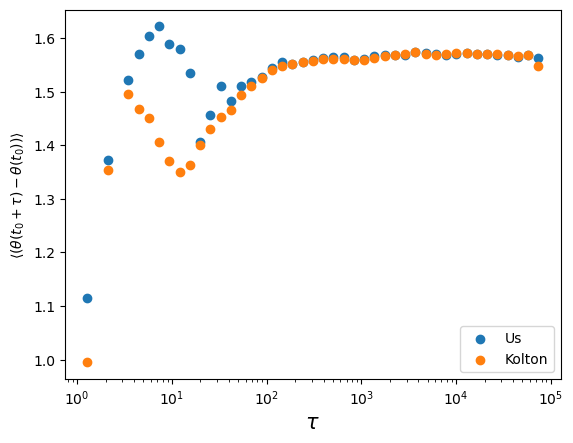

In [17]:
statistic, bin_edges, _ = binned_statistic(epi_df.dt.values, epi_df.dth.values,  bins=np.logspace(0, 5.3))
plt.scatter(bin_edges[1:], statistic, label='Us')
statistic, bin_edges, _ = binned_statistic(kolton_epi_df.dt.values, kolton_epi_df.dth.values,  bins=np.logspace(0, 5.3))
plt.scatter(bin_edges[1:], statistic, label='Kolton')
plt.xscale('log')
plt.legend()
plt.xlabel("$\\tau$", fontsize=15)
plt.ylabel("$\\langle (\\theta(t_0+\\tau)-\\theta(t_0)) \\rangle$")

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
for k, v in chosen_res.items():
     hist, edges = np.histogram(v[0], bins=np.logspace(0.5, 2.8, 30), density=True)
     plt.scatter(edges[:-1], hist, label='$%1.2f$ mT' % k[0])
plt.plot(edges,edges**(-1.26), ls='dashed', c='black', lw=2)
plt.plot(edges,0.3*edges**(-1.11), ls='dashed', c='grey', lw=2)
plt.plot(edges,0.03*edges**(-4/5), ls='-.', c='grey', lw=2)
plt.legend(fontsize=15, loc='lower left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$S \quad (px^2)$", fontsize=20)
plt.ylabel("$P(S)$", fontsize=20)
ax_top = ax.secondary_xaxis('top')
top_ticks = 0.4*0.4*np.array(ax.get_xticks())
ax_top.set_xticks(ax.get_xticks(),[ '$%1.1f \\times 10^{%i}$' % (tp/10**int(np.log10(tp)), int(np.log10(tp))) for tp in top_ticks], fontsize=15)
ax_top.set_xlabel("$S \quad (\mu m^2)$", fontsize=15)
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
for k, v in chosen_res.items():
     hist, edges = np.histogram(v[1], bins=np.logspace(0.1, 1.8, 30), density=True)
     plt.scatter(edges[:-1], hist, label='$%1.2f$ mT' % k[0])
plt.plot(edges,edges**(-1.42), ls='dashed', c='black', lw=2)
plt.plot(edges,0.3*edges**(-1.25), ls='dashed', c='grey', lw=2)
plt.plot(edges,0.02*edges**(-2/3), ls='-.', c='grey', lw=2)
plt.legend(fontsize=15, loc='lower left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\ell \quad (px)$", fontsize=20)
plt.ylabel("$P(\ell)$", fontsize=20)
ax_top = ax.secondary_xaxis('top')
top_ticks = 0.4*np.array(ax.get_xticks())
ax_top.set_xticks(ax.get_xticks(),[ '$%1.1f \\times 10^{%i}$' % (tp/10**int(np.log10(tp)), int(np.log10(tp))) for tp in top_ticks], fontsize=15)
ax_top.set_xlabel("$\ell \quad (\mu m)$", fontsize=15)
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
for k, v in chosen_res.items():
     data_x = v[1]
     data_y = v[0]
     binning = np.logspace(0,np.log10(np.max(data_x)), 40)
     digitized = np.digitize(data_x,binning )
     x_vals = []
     y_vals = []
     for d in digitized:
         mask = digitized == d-1
         if(mask.any()):
             x_vals.append(binning[d-1])
             y_vals.append(np.mean(data_y[mask]))
     plt.scatter(x_vals, y_vals, label='$%1.2f$ mT' % k[0])
plt.xscale('log')
plt.yscale('log')
plt.plot(np.logspace(0, 1.7),1.3*np.logspace(0, 1.7)**(1.63), ls='dashed', c='black', lw=2)
plt.plot(np.logspace(0, 1.7),1.3*np.logspace(0, 1.7)**(2.25), ls='dashed', c='grey', lw=2)
plt.plot(np.logspace(0, 1.7),1.3*np.logspace(0, 1.7)**(1.66), ls='-.', c='grey', lw=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$\ell \quad (px)$", fontsize=20)
plt.ylabel("$\langle S \\rangle \quad (px^2)$", fontsize=20)
plt.legend(fontsize=15, loc="lower right")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(plt.gca().get_ylim()[0], 1e3)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plot_comp = False

for k, v in res_dict.items():
    if(plot_comp):
        condition = k[0]==0.13 and k[2]==chosen_tol and k[1] >= 8 and k[1] <= 16
    else:
        condition =  k[2]==chosen_tol and k[1] == chosen_timecut
    if(condition):
        maj_ax = np.sqrt(v[1])
        min_ax = np.sqrt(np.abs(v[2]))
        area_ellipse = maj_ax*min_ax
        avalanche_sizes = v[0]
        mask = (maj_ax >0)*(min_ax > 0)
        eigs_scaling = stats.linregress(area_ellipse[mask], avalanche_sizes[mask])
        axis_to_pixel = np.sqrt(eigs_scaling[0]/np.pi)
        ell=maj_ax[mask]*axis_to_pixel
        avs = avalanche_sizes[mask]
        if(plot_comp):
            hist, edges = np.histogram(v[0], bins=np.logspace(0.5, 2.7, 30), density=True)
            plt.scatter(edges[:-1], hist, label='$\Delta t = %i$' % k[1])
        else:
            data_x = maj_ax*min_ax
            data_y = v[0]
            binning = np.logspace(0,np.log10(np.max(data_x)), 40)
            digitized = np.digitize(data_x,binning )
            x_vals = []
            y_vals = []
            for d in digitized:
                mask = digitized == d-1
                if(mask.any()):
                    x_vals.append(binning[d-1])
                    y_vals.append(np.mean(data_y[mask]))
            plt.scatter(x_vals, y_vals, label='$%1.2f$ mT' % k[0])
            
if(plot_comp):
    plt.plot(edges,edges**(-1.26), ls='dashed', c='black', lw=2, label="qKPZ")
    plt.plot(edges,0.3*edges**(-1.11), ls='dashed', c='grey', lw=2, label="qEW")
    plt.plot(edges,0.03*edges**(-4/5), ls='-.', c='grey', lw=2, label="equilibrium")
    plt.legend(fontsize=15, loc='lower left')
else:
    plt.plot(np.logspace(0, 2), 10*np.logspace(0,2), ls='dashed', c='black', lw=2, label="$S \sim \sqrt{\lambda_+ \lambda_-}$")
    plt.legend(fontsize=15, loc='upper left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
if(plot_comp):
    plt.xlabel("$S \quad (px^2)$", fontsize=20)
    plt.ylabel("$P(S)$", fontsize=20)
    ax_top = ax.secondary_xaxis('top')
    top_ticks = 0.4*0.4*np.array(ax.get_xticks())
    ax_top.set_xticks(ax.get_xticks(),[ '$%1.1f \\times 10^{%i}$' % (tp/10**int(np.log10(tp)), int(np.log10(tp))) for tp in top_ticks], fontsize=15)
    ax_top.set_xlabel("$S \quad (\mu m^2)$", fontsize=15)
else:
    plt.xlabel("$\sqrt{\lambda+ \lambda_-}$", fontsize=20)
    plt.ylabel("$\langle S \\rangle \quad (px^2)$", fontsize=20)
    plt.ylim(5,plt.gca().get_ylim()[-1])
plt.show()

## $S(q)$

In [ ]:
m_field = 0.16
data = np.loadtxt("thinfilm_data/file_field%1.2f.csv" % m_field, delimiter=',').astype('int')
nrows, ncols  = data.shape

In [ ]:
no_event_regions = [ r.astype('int') for r in measure.find_contours(data,-1)]
no_event_regions_sizes = np.array([r.shape[0] for r in no_event_regions])
sorted_regions_idx = np.argsort(no_event_regions_sizes)
inner_region = no_event_regions[sorted_regions_idx[-2]]
outer_region = no_event_regions[sorted_regions_idx[-1]]

In [ ]:
ii, jj = np.meshgrid(np.arange(0,nrows), np.arange(0,ncols), indexing='ij')
pts = np.vstack([ii.flatten(), jj.flatten()])


outer_hull = ConvexHull(outer_region)
outer_mask = np.ones((nrows, ncols), dtype=bool)
for eq in outer_hull.equations:
    eq_mask = np.dot(eq[:-1], pts) + eq[-1] <= 1e-12
    outer_mask[ii.flatten(),jj.flatten()] *= eq_mask

inner_hull = ConvexHull(inner_region)
inner_mask = np.ones((nrows, ncols), dtype=bool)
for eq in inner_hull.equations:
    eq_mask = np.dot(eq[:-1], pts) + eq[-1] <= 1e-12
    inner_mask[ii.flatten(),jj.flatten()] *= eq_mask

no_crown_mask = ~(outer_mask*(1-inner_mask))

In [ ]:
temp_inner = np.zeros_like(data)
temp_inner[inner_mask] = 1
event_mask = data > - 1
interface_dict = {}
for t in range(0, data.max()+1):
    if(t%500 == 0):
        print(t)
    temp = np.copy(temp_inner)
    temp[event_mask*(data<=t)] = 1
    regions = measure.find_contours(temp)
    r_sizes = [len(r) for r in regions]
    largest_r = regions[np.argmax(r_sizes)].astype('int')
    interface_dict[t] = largest_r

In [ ]:
#interface_dict = np.load("interface_recon%1.2f.npy" % field, allow_pickle=True).item()

In [ ]:
center = inner_region.mean(axis=0)
r_mean = np.array([   np.sqrt((h[:, 0] - center[0])**2+(h[:, 1]-center[1])**2).mean() for t, h in interface_dict.items()])

In [ ]:
%matplotlib inline
center = inner_region.mean(axis=0)
theta_new = np.linspace(-np.pi, np.pi, 2**11)
interface_data_interp = []
for t, h in interface_dict.items():
    theta = np.arctan2(h[:, 0] - center[0], h[:, 1]-center[1])
    rho = np.sqrt((h[:, 0] - center[0])**2+(h[:, 1]-center[1])**2)
    rho_new =  np.interp(theta_new, theta, rho, period=np.pi*2)
    interface_data_interp.append(rho_new)
interface_data_interp = np.array(interface_data_interp)

In [ ]:
interface = [np.copy(interface_data_interp[0])]
for t in range(1, interface_data_interp.shape[0]):
    new_interface = np.copy(interface_data_interp[t])
    mask_receeded = new_interface-interface[-1] < 0
    new_interface[mask_receeded] = interface[-1][mask_receeded]
    interface.append(new_interface)
    #print("Fixed sites: ", mask_receeded.sum())
interface = np.array(interface)

In [ ]:
np.save("interface_interp_%1.2f.npy" % m_field, interface)

In [ ]:

#b_r = fft.ifft(s_q).real/n_theta
#b_r -= b_r[:, 0:1]
#b_r = -b_r

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
for m_field in [0.13, 0.14, 0.15, 0.16]:
    interface = np.load("interface_interp_%1.2f.npy" % m_field)
    q = fft.fftfreq(interface.shape[1])
    L = interface.shape[1]
    if(m_field == 0.13):
        h_q = fft.fft((interface-interface.mean(axis=1)[:,None])[100:,:], axis=1)
    else:
        h_q = fft.fft((interface-interface.mean(axis=1)[:,None])[-40000:,:], axis=1)
    s_q = h_q*np.conj(h_q)
    plt.scatter(2*np.pi*q[q>0],s_q.real.mean(axis=0)[q>0], s=5, label='$%1.2f$ mT' % m_field)
plt.plot(2*np.pi*q[q>0],5/q[q>0]**2.26,ls='dashed', c='black', lw=2) #, label="qKPZ")
plt.plot(2*np.pi*q[q>0],5/q[q>0]**2.33,ls='dashed', c='grey', lw=2) #, label="qEW")
plt.plot(2*np.pi*q[q>0],5/q[q>0]**3.50,ls='-.', c='grey', lw=2) #label="equilibrium")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$q \quad (\\rm{rad^{-1}})$", fontsize=20)
plt.ylabel("$S(q)$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(plt.gca().get_ylim()[0], 1e9)
lgnd = plt.legend(fontsize=15, loc='lower left')
lgnd.legendHandles[0]._sizes = [36]
lgnd.legendHandles[1]._sizes = [36]
lgnd.legendHandles[2]._sizes = [36]
lgnd.legendHandles[3]._sizes = [36]
plt.tight_layout()
plt.savefig("sq.png",dpi=300)
plt.show()

In [ ]:
delta_theta = theta[1]-theta[0]
plt.plot(np.arange(1, n_theta//2),b_r[10000:20000:,1: n_theta//2].mean(axis=0))
plt.plot(np.arange(1, n_theta//2), 0.3*np.arange(1, n_theta//2)**1.63)
plt.plot(np.arange(1, n_theta//2), 0.3*np.arange(1, n_theta//2)**1.66)
plt.plot(np.arange(1, n_theta//2), 0.3*np.arange(1, n_theta//2)**2.25)
plt.xscale('log')
plt.yscale('log')